<a href="https://colab.research.google.com/github/russodanielp/intro_cheminformatics/blob/master/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

## Aim

To understand the basics of a neural network and to create a simple deep learning neural network using PyTorch.

## Objectives 

* Create a simple deep learning model using PyTorch

## Background

The explosion of the amounts of accessible, publically available data couples with hardware advances such as graphical processing units (GPUs) has lead to the resurgances of deep learning methods.  Deep learning is a catch-all term for various types of artificial neural networks, which have seen in the QSAR lab.  A simple neural network generally consists of one input later, a hidden layer, and an output layer.  However, this framework can be extended to include any number of hidden layers.  When an artificial neural network contains more than 1 hidden layer, it is called a deep neural network.  

Part of Python's popularity is the number of deep learning libraries.  The [PyTorch](https://pytorch.org/) is one of the most popular and will be used in this tab to create a fairly standard neural network of 3 hidden layers.  


In this lab we will use a dataset provided by the dataset provided by [NICEATM Acute Oral Toxicity challenge](https://ehp.niehs.nih.gov/doi/10.1289/EHP8495).  In this challenge, over 11,000 chemicals with acute oral toxicity values LD$_{50}$, which is defined as the median concentraion at which 50% of the tested animal subjects die after substance ingestion.  Of these chemicals a training set what provided to modeling participants (labeled `TrainingSet.sdf` in the `data` folder).  We will use this to create a neural network using PyTorch. 

In [2]:
import numpy as np
import torch
from torch import nn
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

## Data Preperation

We can prepare the data just as we have for our QSAR methods.

In [3]:
def calc_fp_from_mol(mol, method="maccs", n_bits=2048):
    """
    Encode a molecule from a RDKit Mol into a fingerprint.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    if method == "maccs":
        return list(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan4":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan6":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return list(MACCSkeys.GenMACCSKeys(mol))

RDKit WARNING: [16:16:49] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [16:16:49] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [16:16:49] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [16:16:49] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [16:16:52] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [16:16:53] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [16:16:53] Warning: molecule is tagged as 3D, but all Z coords are zero


,CASRN,DTXSID,Name,Structure_Source,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,Original_SMILES,Canonical_QSARr,InChI_Code_QSARr,InChI Key_QSARr,Salt_Solvent,Conv_Info,Enrg_Info,ID,ROMol
0,7545-48-4,,,Public_CrossChecked,FALSE,TRUE,12000.0,4,5,C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)([O-])[O-])...,OC1C(COP(O)(O)=O)OC(C1O)N1C=CC(=O)NC1=O,InChI=1S/C9H13N2O9P/c12-5-1-2-11(9(15)10-5)8-7...,DJJCXFVJDGTHFX-UHFFFAOYSA-N,[Na+].[Na+],true,-211.68226084448955,17743,
1,134528-32-8,,,Public_CrossChecked,FALSE,TRUE,,3,5,C1=C(C(=O)NC(=O)N1C2C(C(C(O2)CO)O)O)C=CBr,OCC1OC(C(O)C1O)N1C=C(C=CBr)C(=O)NC1=O,InChI=1S/C11H13BrN2O6/c12-2-1-5-3-14(11(19)13-...,GCQYYIHYQMVWLT-UHFFFAOYSA-N,?,true,2.7756185873526507,10555,
2,17902-23-7,,,Public_CrossChecked,FALSE,FALSE,930.0,3,4,C1CC(OC1)N2C=C(C(=O)NC2=O)F,O=C1NC(=O)C(F)=CN1C1CCCO1,InChI=1S/C8H9FN2O3/c9-5-4-11(6-2-1-3-14-6)8(13...,WFWLQNSHRPWKFK-UHFFFAOYSA-N,?,true,-70.26435136661355,15003,

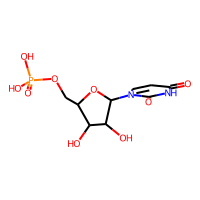
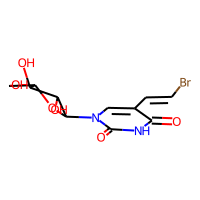
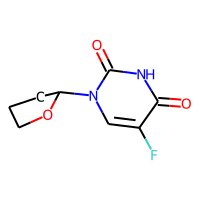

In [4]:
df = PandasTools.LoadSDF('data/TrainingSet.sdf')
df.head(3)

Let's remove data without LD$_{50}$ data. 

,CASRN,DTXSID,Name,Structure_Source,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,Original_SMILES,Canonical_QSARr,InChI_Code_QSARr,InChI Key_QSARr,Salt_Solvent,Conv_Info,Enrg_Info,ID,ROMol
0,7545-48-4,,,Public_CrossChecked,FALSE,TRUE,12000.0,4,5,C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)([O-])[O-])...,OC1C(COP(O)(O)=O)OC(C1O)N1C=CC(=O)NC1=O,InChI=1S/C9H13N2O9P/c12-5-1-2-11(9(15)10-5)8-7...,DJJCXFVJDGTHFX-UHFFFAOYSA-N,[Na+].[Na+],true,-211.68226084448955,17743,
2,17902-23-7,,,Public_CrossChecked,FALSE,FALSE,930.0,3,4,C1CC(OC1)N2C=C(C(=O)NC2=O)F,O=C1NC(=O)C(F)=CN1C1CCCO1,InChI=1S/C8H9FN2O3/c9-5-4-11(6-2-1-3-14-6)8(13...,WFWLQNSHRPWKFK-UHFFFAOYSA-N,?,true,-70.26435136661355,15003,
3,27942-00-3,,,Public_CrossChecked,FALSE,TRUE,8150.0,4,5,CN1C=CC(=O)NC1=O,CN1C=CC(=O)NC1=O,"InChI=1S/C5H6N2O2/c1-7-3-2-4(8)6-5(7)9/h2-3H,1...",XBCXJKGHPABGSD-UHFFFAOYSA-N,?,true,-87.22216620737237,17566,
5,80834-51-1,,,Public_CrossChecked,FALSE,FALSE,500.0,2,4,CCC(C(=O)C1=CC2=C(C=C1)NC(=O)C=C2)N3CCN(CC3)C4...,CCC(C(=O)c1cc2C=CC(=O)Nc2cc1)N1CCN(CC1)c1cc(Cl...,InChI=1S/C23H24ClN3O2/c1-2-21(23(29)17-6-8-20-...,LVCUAMMHDAVDEZ-UHFFFAOYSA-N,?,true,144.6181349380037,14260,
6,80834-80-6,,,Public_CrossChecked,FALSE,FALSE,500.0,2,4,CCOC1=CC=CC=C1N2CCN(CC2)CCC=CC3=CC4=C(C=C3)NC(...,CCOc1ccccc1N1CCN(CCC=Cc2cc3C=CC(=O)Nc3cc2)CC1,InChI=1S/C25H29N3O2/c1-2-30-24-9-4-3-8-23(24)2...,WTQXWMCWQHOPRX-UHFFFAOYSA-N,?,true,137.79606898256017,14279,

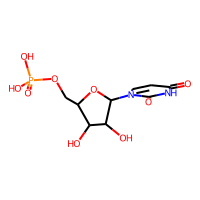
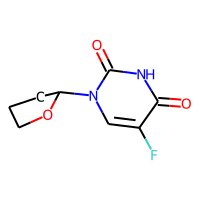
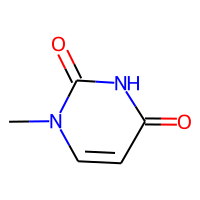
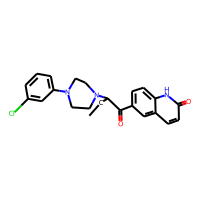
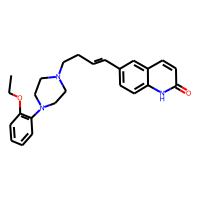

In [5]:
df = df[df.LD50_mgkg != '']
df['LD50_mgkg'] = df['LD50_mgkg'].astype(float)
df.head()

In [6]:
import math

In [7]:
desc_list = []


for mol in df.ROMol.tolist():
    desc = calc_fp_from_mol(mol, method='morgan6', n_bits=1024)
    desc_list.append(desc)

    
X = pd.DataFrame(desc_list)
y = df['LD50_mgkg'].astype(float).apply(lambda x: math.log10(x))

In [8]:
%matplotlib inline

<AxesSubplot:>

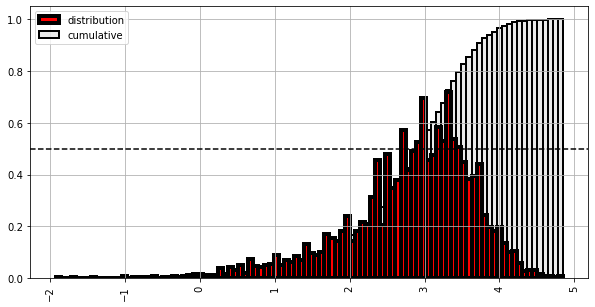

In [9]:
ax = y.hist(bins=100, edgecolor='k', lw=4, facecolor=(1, 0, 0, 1), figsize=(10,5), xrot=90, density=True, label='distribution')
y.hist(cumulative=True, density=1, bins=100, label='cumulative', zorder=0, facecolor=(0.8, 0.8, 0.8, 0.4), edgecolor='k', lw=2, figsize=(10,5))
ax.axhline(0.5, ls='--', c='k')
ax.legend()
ax

The above plot shows that about half the LD50 data points lie above a log(3) and half lie below, so we can use that as our activitiy classification cutoffs.  

We need to validate our model.  A typical DNN is usually trained on hundreds to thousands of data points and need to optimize millions of parameters.  For this type of scenario, cross validation as we did in the QSAR lab, would require splitting our data into multiple tests sets, which is often not practical without the help of a (or several) GPU(s).  

For validation, we will split our data into a validation set consisting of 20% of our compounds.  

In [124]:
from sklearn.model_selection import KFold, train_test_split
SEED = 2008


y_binary = y.copy()
y_binary[y < 3] = 1
y_binary[y >= 3] = 0

# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')

# y_binary = enc.fit_transform(y_binary.values.reshape(-1, 1)).toarray()

X_train, X_val, y_train, y_val = train_test_split(X, y_binary , test_size=0.2, random_state=SEED)

X_train, X_val, y_train, y_val = X_train.values.astype('float32'), X_val.values.astype('float32'), y_train.values.astype('float32'), y_val.values.astype('float32')

## Model Building

Building a deep learning network requires knowledge of how to create a `class` and objects in Python.  It's beyond the scope of this lab, but in the cell below a simple deep neural network of 2 hidden layers has been created for you.  

In [157]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, in_features=1024, 
                 out_features=1):
        super().__init__()
        self.input = nn.Linear(in_features=in_features,
                             out_features=100)
        self.hl_1 = nn.Linear(in_features=100, 
                             out_features=100)
        self.hl_2 = nn.Linear(in_features=100, 
                             out_features=100)
        self.hl_3 = nn.Linear(in_features=100, 
                             out_features=100)
        self.output = nn.Linear(in_features=100,  
                             out_features=out_features)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, X):
        X = nn.functional.relu(self.input(X))
        X = self.dropout(X)
        X = nn.functional.relu(self.hl_1(X))
        X = self.dropout(X)
        X = nn.functional.relu(self.hl_2(X))
        X = self.dropout(X)
        X = nn.functional.relu(self.hl_3(X))
        X = self.dropout(X)
        return nn.functional.sigmoid(self.output(X))

In [168]:
model = NeuralNetwork().to('cpu')
print(model)

NeuralNetwork(
  (input): Linear(in_features=1024, out_features=100, bias=True)
  (hl_1): Linear(in_features=100, out_features=100, bias=True)
  (hl_2): Linear(in_features=100, out_features=100, bias=True)
  (hl_3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


After designing the neural network we need to decide which methods we need to train.  For this we will use [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) and define a [loss function](https://en.wikipedia.org/wiki/Loss_function), which in our case is [binary cross entropy](https://en.wikipedia.org/wiki/Binary_entropy_function).  

In [169]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Model training

Model training a neural network works by taking epochs, also known as steps.  Mathematically, it is an optimization problem where we are trying to find the neural network parameters which minimize the loss function.  In this case our loss function is binary cross entroy, which is how well our model is predicting our classes (0, 1).  After every epoch, the loss is calculated and for each parameters some calculus is applied to figure our which way we should adjust these parameters such that the loss will be lower the next epoch.  This is usually repeated until some specified number of training epochs or some other stopping point.  

__NOTE:__  Depending on the your CPU hardware, training the model by running the cell below could take a significant time period.  

In [170]:
EPOCHS = 500
losses = []
val_losses = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(torch.from_numpy(X_train))
    loss = criterion(outputs, torch.from_numpy(y_train.reshape(-1, 1)))

    loss.backward()
    optimizer.step()
    with torch.no_grad():
        val_outputs =  model(torch.from_numpy(X_val))
        val_loss =  criterion(val_outputs, torch.from_numpy(y_val.reshape(-1, 1)))
        
    # print statistics
    running_loss += loss.item()
    losses.append(loss.item())
    val_losses.append(val_loss.item())
    if epoch % 100 == 0:
        print(f"Finished training epoch {epoch}, training loss is at {loss.item()}, validation loss is at {val_loss.item()}")

print('Finished Training')

/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Finished training epoch 0, training loss is at 0.6959757208824158, validation loss is at 0.6933385133743286
Finished training epoch 100, training loss is at 0.025788022205233574, validation loss is at 6.280280113220215
Finished training epoch 200, training loss is at 0.01797558180987835, validation loss is at 7.286870002746582
Finished training epoch 300, training loss is at 0.016952097415924072, validation loss is at 8.706257820129395
Finished training epoch 400, training loss is at 0.018198644742369652, validation loss is at 8.472963333129883
Finished Training


## Training Plots

It's often common to monitor the loss function 

In [171]:
%matplotlib inline

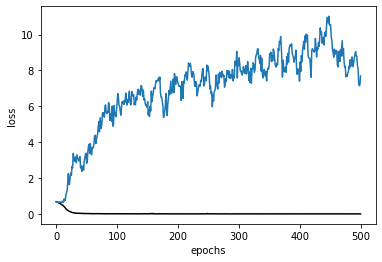

In [172]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(range(EPOCHS), losses, c='k', label='training loss')
ax.plot(range(EPOCHS), val_losses, label='validation loss')

ax.set_ylabel('loss')
ax.set_xlabel('epochs')
plt.show()

We can calcuate the statistics on the validation set to assess model performance as we did before in the QSAR module.  

In [173]:
with torch.no_grad():
    val_outputs =  model(torch.from_numpy(X_val))
    
preds = val_outputs.numpy()

preds[val_outputs >0.5] = 1
preds[val_outputs <= 0.5] = 0
print(val_outputs.numpy())

[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [1.]]


In [174]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

accuracy = accuracy_score(y_val, preds)
sens = recall_score(y_val, preds)
spec = recall_score(y_val, preds, pos_label=0)
auc = roc_auc_score(y_val, preds)


# Print statistics of results
print(f"Accuracy is {accuracy}")

Accuracy is 0.6956198960653304


In [175]:
sens

0.7470414201183432

In [176]:
spec

0.6438152011922503

In [177]:
auc

0.6954283106552968